# Physics 240 - Assignment 2

# Ramon Ciutad Perez

This code must be read along with the handwritten notebook, which includes all formulas used here and their derivations.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so
import scipy.special as se
import scipy.stats as ss
import scipy.integrate as si
import emcee
import corner
from tqdm import tqdm

## Problem 1 : Outlier Treatment and Bootstrapping

# 1) a)

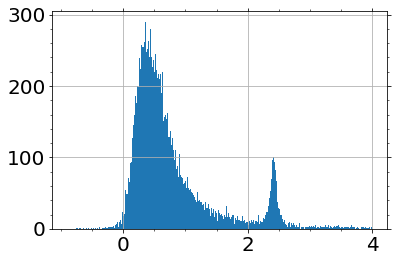

In [2]:
# Exercise 1 part a
plt.style.use('phys240.mplstyle')

t = fits.open('NGC2516_Gaia.fits.gz')[1].data

parallaxes = t['parallax'][np.argwhere(t['parallax'] < 4)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(parallaxes, bins=400)
plt.show()

# 1) b)

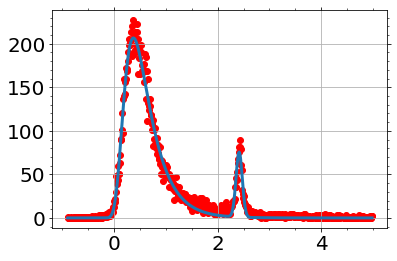

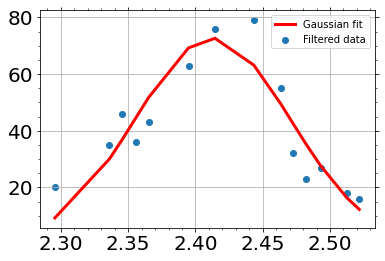

The parallax of the cluster after filtering out the outliers was found to be: 2.413 ± 0.058
Using bootstrap resampling, the parallax of the cluster was found to be:2.416 ± 0.005


In [3]:
# Exercise 1 part b
def prob_bad_and_good(x, A_bad, mean_bad, scale_bad, A_good, mean_good, scale_good):
    gaussian = A_good * np.exp(-(x - mean_good)**2/(2 * scale_good**2))
    # gaussian = A_good * ss.norm.pdf(x, mean_good, scale_good)
    moyal = A_bad * ss.moyal.pdf(x, loc=mean_bad, scale=scale_bad)
    return gaussian + moyal

def moyal(x, A_bad, mean_bad, scale_bad):
    return A_bad * ss.moyal.pdf(x, loc=mean_bad, scale=scale_bad)

def gaussian(x, A_good, mean_good, scale_good):
    return A_good * np.exp(-(x - mean_good)**2/(2 * scale_good**2))


parallaxes= t['parallax']
parallaxes_errs = t['parallax_error']

# Create data points from histogram (parallax for the x-axis, counts for the y-axis, and errors on y)
data, bins = np.histogram(parallaxes, bins=600)
p_points_original = np.array([])
p_errors_original = np.array([])
counts_original = np.array([])
for i in range(len(bins) - 1):

    if i < len(bins) - 1:
        indices = np.argwhere(np.logical_and(parallaxes >= bins[i], parallaxes < bins[i+1]))
    elif i == len(bins) - 1:
        indices = np.argwhere(np.logical_and(parallaxes > bins[i], parallaxes <= bins[i+1]))

    if len(indices) != 0: #Create a weighted datapoint from the histogram
        p_points_original = np.append(p_points_original, np.average(parallaxes[indices]))
        p_errors_original = np.append(p_errors_original, np.average(parallaxes_errs[indices]))
        
    if len(indices) == 0: #For empty bins, create the datapoint with 0 value and error
        p_points_original = np.append(p_points_original, np.average([bins[i], bins[i+1]]))
        p_errors_original = np.append(p_errors_original, 0)
        
    counts_original = np.append(counts_original, data[i])

def analysis(p_points, p_errors, counts, plot=False, output_original_params_and_priors=False):
    # Fit the entire model of likelihoods (good + bad) to the data to get a rough estimate
    params = so.curve_fit(prob_bad_and_good, p_points, counts, p0=[150, 0.37, 0.17, 75, 2.4, 0.05])[0]
    model = prob_bad_and_good(p_points, params[0], params[1], params[2], params[3], params[4], params[5])
    
    # Find prior probabilities of a point being bad (outlier) or good (cluster member)
    indices_good = np.where(np.logical_and(p_points > 2.25, p_points < 2.6))[0]
    prior_good = len(indices_good) / len(parallaxes)
    prior_bad = 1 - prior_good
    
    if output_original_params_and_priors:
        return params, prior_good, prior_bad
    
    else:
        if plot:
            plt.plot(p_points, model)
            plt.scatter(p_points, counts, c='r')
            plt.show()
            
        # Normalize the good and bad likelihoods by numerical integration:
        norm_good = si.quad(gaussian, p_points[0], p_points[-1], args=(params[3], params[4], params[5]))[0]
        norm_bad = si.quad(moyal, p_points[0], p_points[-1], args=(params[0], params[1], params[2]))[0]
        
        # Find the good and bad likelihoods
        likelihood_good = gaussian(p_points, params[3], params[4], params[5]) / norm_good
        likelihood_bad = moyal(p_points, params[0], params[1], params[2]) / norm_bad
        
        
        # Find the posterior probability for every datapoint and reject it if
        # the posterior is bigger than a random number between 0 and 1
        
        filtered_p = np.array([])
        filtered_counts = np.array([])
        for i in range(len(p_points)):
            if likelihood_bad[i] == 0:
                posterior_bad = 1
            else:
                posterior_bad = (1 + (prior_good * likelihood_good[i]) / (prior_bad * likelihood_bad[i]))**(-1)
                
            if np.random.rand() > posterior_bad:
                filtered_p = np.append(filtered_p, p_points[i])
                filtered_counts = np.append(filtered_counts, counts[i])
                
        params_filtered = so.curve_fit(gaussian, filtered_p, filtered_counts, p0=[params[3], params[4], params[5]], )[0]      
        
        # print(params_filtered[2]/np.sqrt(len(p_points)))
      
        return params_filtered, filtered_p, filtered_counts


params_final, x_points, y_points = analysis(p_points_original, p_errors_original, counts_original, plot=True)
plt.plot(x_points, gaussian(x_points, params_final[0], params_final[1],
                            params_final[2]), c='r', label='Gaussian fit')
plt.scatter(x_points, y_points, label='Filtered data')
plt.legend(fontsize=10)
plt.show()

print('The parallax of the cluster after filtering out the outliers was found to be: {0:.3f} ± {1:.3f}'.
      format(params_final[1], abs(params_final[2])))


# Bootstrap
n_iterations = 100
means_array = np.array([])
for sample in range(n_iterations):
    indices_sample = np.random.randint(0, len(p_points_original), len(p_points_original))
    indices_sample = np.array(sorted(list(indices_sample)))
    p_points_sample = p_points_original[indices_sample]
    p_errors_sample = p_errors_original[indices_sample]
    counts_sample = counts_original[indices_sample]
    mean_sample = analysis(p_points_sample, p_errors_sample, counts_sample)[0][1]
    means_array = np.append(means_array, mean_sample)

average_peak = np.average(means_array)
error_peak = np.std(means_array)

print('Using bootstrap resampling, the parallax of the cluster was found to be:{0:.3f} ± {1:.3f}'.format(average_peak, error_peak))

# 1) c)

In [4]:
# Exercise 1 part c
pm_x = t['pmra']
pm_x_error = t['pmra_error']
pm_y = t['pmdec']
pm_y_error = t['pmdec_error']

data_original = np.array([pm_x, pm_x_error, pm_y, pm_y_error, parallaxes, parallaxes_errs])

This is the observed distribution of proper motion in the x direction:

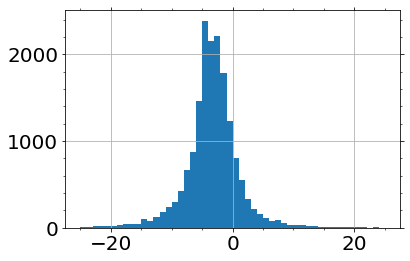

In [5]:
plt.hist(pm_x, bins=50, range=(-25, 25))
plt.show()

And this is the gaussian funtion that we'll use to represent it:

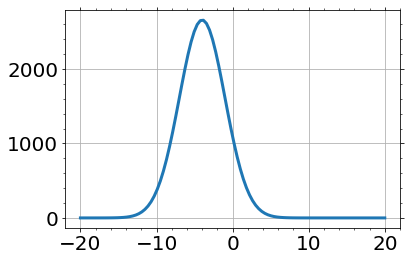

In [6]:
plt.plot(np.linspace(-20, 20, 100), 20000*ss.norm.pdf(np.linspace(-20, 20, 100), -4, 3))
plt.show()

Similarly, this is the observed distribution of proper motion in the y direction:

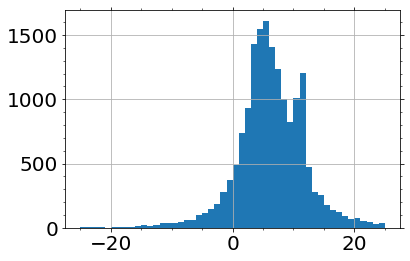

In [7]:
plt.hist(pm_y, bins=50, range=(-25, 25))
plt.show()

And this is the gaussian funtion that we'll use to represent it:

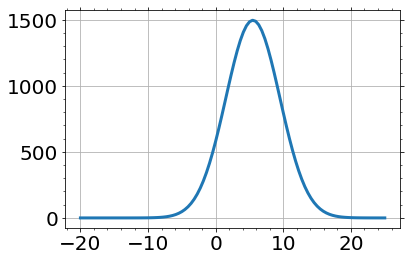

In [8]:
plt.plot(np.linspace(-20, 25, 100), 15000*ss.norm.pdf(np.linspace(-20, 25, 100), 5.5, 4))
plt.show()

Finally, as explained earlier in the handwritten notes, for the distribution of parallaxes, we'll use the Moyal dsitribution as fitted in part b), which is good enough as a rough approximation.

In [16]:
def log_likelihood(parameters, data=data_original, return_posterior=False):
    pm_x_array = data[0]
    pm_x_error_array = data[1]
    pm_y_array = data[2]
    pm_y_error_array = data[3]
    parallax_array = data[4]
    parallax_error_array = data[5]
    
    
    pm_x_cluster, pm_x_cluster_error, pm_y_cluster, pm_y_cluster_error, parallax_cluster = parameters
    
    # Start by finding the likelihood in the case of a cluster member
    A = 1 / ((2*np.pi)**(3/2) * np.sqrt((pm_x_error_array**2 + pm_x_cluster_error**2) * (pm_y_error_array**2 + pm_y_cluster_error**2) * parallax_error_array**2))
    first_term = (pm_x_array - pm_x_cluster)**2 / (pm_x_error_array**2 + pm_x_cluster_error**2)
    second_term = (pm_y_array - pm_y_cluster) **2 / (pm_y_error_array**2 + pm_y_cluster_error**2)
    third_term = (parallax_array - parallax_cluster) ** 2 / parallax_error_array**2
    
    likelihood_good = A * np.exp(-1/2 * (first_term + second_term + third_term))
    
    # Now find the likelihood in the case of an outlier
    L_bad_pm_x = ss.norm.pdf(pm_x_array, -4, 3) 
    L_bad_pm_y = ss.norm.pdf(pm_y_array, 5.5, 4)
    # For the moyal distribution, retrieve the parameters from part b) as well as the priors
    params_moyal, prior_good, prior_bad = analysis(p_points_original, p_errors_original, counts_original, output_original_params_and_priors=True)
    moyal_mean, moyal_scale = params_moyal[1:3]
    L_bad_parallax = ss.moyal.pdf(parallax_array, loc=moyal_mean, scale=moyal_scale)
    
    likelihood_bad = L_bad_pm_x * L_bad_pm_y * L_bad_parallax
    
    L_array = prior_bad * likelihood_bad + prior_good * likelihood_good
    
    if return_posterior:
        posterior_array = np.array([])
        indices_list = []
        for i in range(len(L_array)):
            if prior_bad * likelihood_bad[i] > 1e-10 :
                posterior_element = 1 - (1 + (prior_good * likelihood_good[i]) / (prior_bad * likelihood_bad[i])) ** (-1)
                posterior_array = np.append(posterior_array, posterior_element)
                indices_list.append(i)
        
        return posterior_array, indices_list
        
    # total_log_L = 0
    # for element in L_array:
    #     if element > 0:
    #         total_log_L += np.log(element)
    L_array = L_array[np.argwhere(L_array > 1e-5)]
    total_log_L = np.sum(np.log(L_array))
    
    return -total_log_L

resulting_params = so.minimize(log_likelihood, [-5, 2, 10, 2, 2.5]).x


# Now do bootstrap resampling to find the uncertainties on the parameters
n_iterations = 100
params_array = np.empty((0, 5))
for sample in range(n_iterations):
    indices_sample = np.random.randint(0, len(parallaxes), len(parallaxes))
    indices_sample = np.array(sorted(list(indices_sample)))
    data_sample = data_original[:,indices_sample]
    params_sample = so.minimize(log_likelihood, [-5, 2, 10, 2, 2.5], args=(data_sample, False)).x
    params_sample = np.reshape(params_sample, (1, 5))
    params_array = np.vstack((params_array, params_sample))

average_params = np.average(params_array, axis=0)
error_params = np.std(params_array, axis=0)


print('After applying bootstrap resampling, the optimized parameters are the following:')
print("The cluster's mean proper motion in the x direction is: ({0:.3f} ± {1:.3f}) mas/yr".format(average_params[0], error_params[0]))
print("The width of the x-proper motion is: ({0:.3f} ± {1:.3f}) mas/yr".format(average_params[1], error_params[1]))
print("The cluster's mean proper motion in the y direction is: ({0:.3f} ± {1:.3f}) mas/yr".format(average_params[2], error_params[2]))
print("The width of the x-proper motion is: ({0:.3f} ± {1:.3f}) mas/yr".format(average_params[3], error_params[3]))
print("The cluster's mean parallax is: ({0:.3f} ± {1:.3f}) mas/yr".format(average_params[4], error_params[4]))

After applying bootstrap resampling, the optimized parameters are the following:
The cluster's mean proper motion in the x direction is: (-4.682 ± 0.015) mas/yr
The width of the x-proper motion is: (0.268 ± 0.358) mas/yr
The cluster's mean proper motion in the y direction is: (11.180 ± 0.015) mas/yr
The width of the x-proper motion is: (0.389 ± 0.016) mas/yr
The cluster's mean parallax is: (2.416 ± 0.001) mas/yr


# 1) d)

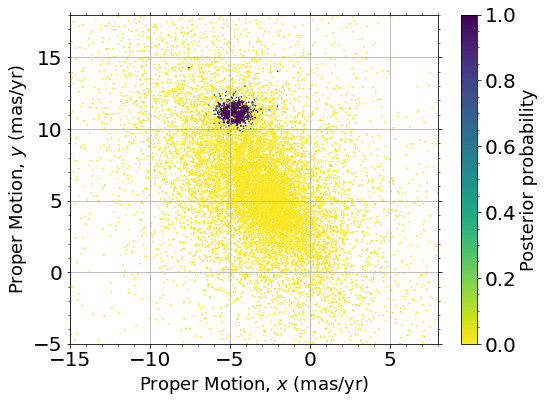

In [10]:
# Exercise 1 part d
posterior, indices = log_likelihood(resulting_params, return_posterior=True)

plt.figure(figsize=(8, 6))
plt.scatter(t['pmra'][indices], t['pmdec'][indices], c=posterior, s=0.5, cmap="viridis_r", vmin=0, vmax=1)
plt.xlim(-15, 8)
plt.ylim(-5, 18)
plt.colorbar(label="Posterior probability")
plt.xlabel(r"Proper Motion, $x$ (mas/yr)")
plt.ylabel(r"Proper Motion, $y$ (mas/yr)")
plt.tight_layout()
plt.savefig("NGC2516_figure.pdf")

As we can see, these results are pretty satisfactory, with the exception of a few (apparent) outliers near the cluster

## Problem 2 : MCMC

In [11]:
data = np.genfromtxt('skytemperature.csv', delimiter=',', skip_header=True)
frequencies_unormalized = data[3:126, 0]
T_sky = data[3:126, 2]
frequencies_matrix = np.reshape(frequencies_unormalized/75, (len(T_sky), 1))
data_matrix = np.reshape(T_sky, (len(T_sky), 1))

cov_power = np.diag(np.ones(len(T_sky)) * 1/0.025)

def create_row(nu, c1, c2, c3):
    array = np.array([nu**-2.5, nu**-2.5 * np.log(nu),
                      nu**-2.5 * np.log(nu)**2 , nu**-4.5, nu**-2,
                      np.exp(-abs((nu - c1)/c2)**np.sqrt(c3**2))])
    return np.reshape(array, (1, 6)) 

# Exercise 2 part 3 part a)
def create_A_matrix_2(c1, c2, c3):
    A_matrix = create_row(frequencies_matrix[0][0], c1, c2, c3)
    for i in range(1, len(frequencies_matrix)):
        A_matrix = np.vstack((A_matrix, create_row(frequencies_matrix[i][0], c1, c2, c3)))
    return A_matrix

def sampling_log_likelihood(non_linear_params):
    c1, c2, c3 = non_linear_params
    A = create_A_matrix_2(c1, c2, c3)
    
    theta_MLE = np.linalg.lstsq(np.dot(cov_power, A), np.dot(cov_power, data_matrix), rcond=None)[0]
    theta_MLE_cov = np.linalg.inv(np.dot(A.T, np.dot(cov_power**2, A)))
    
    model = np.dot(A, theta_MLE)
    
    return np.log(np.sqrt(np.linalg.det(theta_MLE_cov))) + (-0.5 * np.dot((data_matrix - model).T, np.dot(cov_power**2, (data_matrix - model))))

# Try for a certain set of parameters c1, c2 nd c3
print(sampling_log_likelihood([1.05, 0.1, 8])[0][0])

-350.1967709248513


Now let's try the same thing but in full:

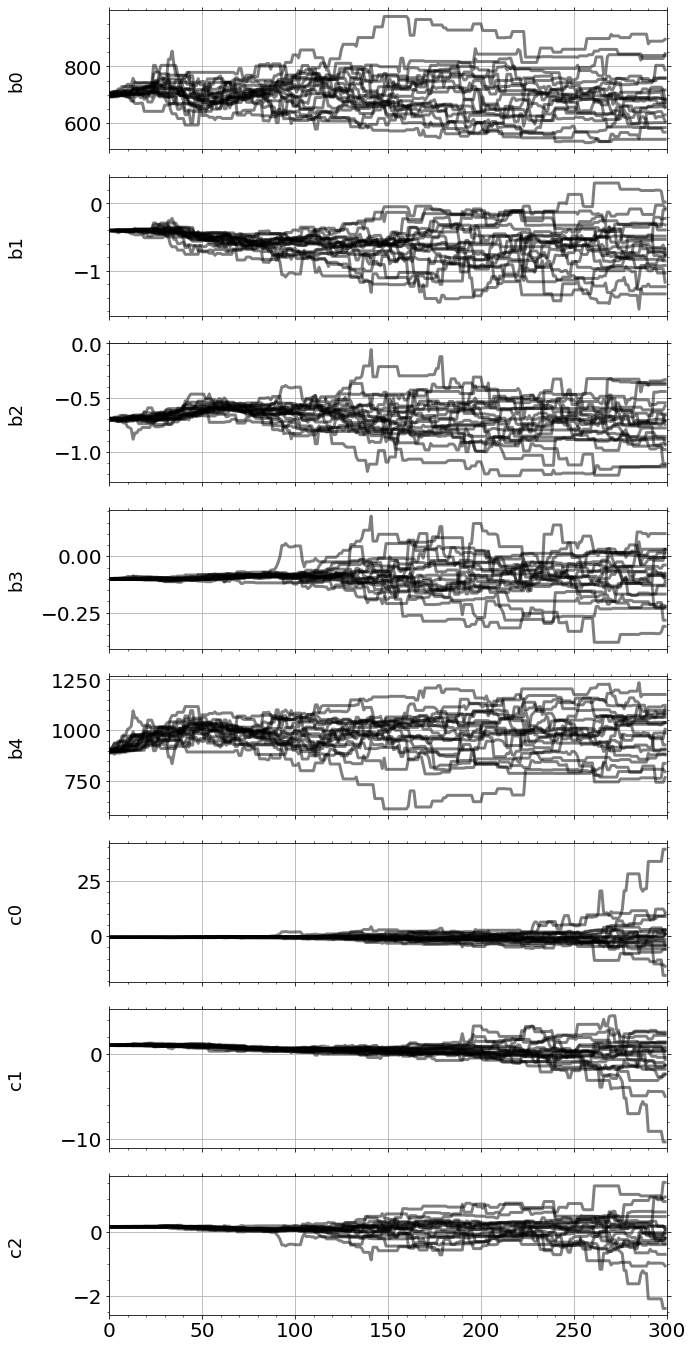

In [12]:
A = 0.025**2
B = 2 * A

cov_full = np.empty((0, len(frequencies_unormalized)))
for freq1 in frequencies_unormalized:
    temp = np.array([])
    for freq2 in frequencies_unormalized:
        to_append = B * np.cos(0.3 * (freq1 - freq2)) * np.exp(-np.abs((freq1 - freq2)/60))
        if freq1 == freq2:
            to_append += A
        temp = np.append(temp, to_append)
    cov_full = np.vstack((cov_full, temp))

def true_sampling_log_likelihood(params):

    term1 = -2.5 + params[1] + params[2]*np.log(frequencies_matrix)
    term2 = -params[3] * frequencies_matrix**(-2)
    T = params[0] * np.power(frequencies_matrix, term1) * np.exp(term2) + params[4]*frequencies_matrix**(-2) + \
        params[5] * np.exp(-np.power(np.abs((frequencies_matrix - params[6])/params[7]), 2.8))

    return -0.5 * np.dot((data_matrix - T).T, np.dot(cov_full, (data_matrix - T)))


no_walkers = 20
n_dim = 8
guesses = np.empty((0, n_dim))
for _ in range(no_walkers):
    temp = [700, -0.4, -0.7, -0.1, 900, -0.5, 1, 0.15]
    for index, val in enumerate(temp):
        noise = val / 100
        temp[index] = np.random.uniform(val - noise, val + noise)
    guesses = np.vstack((guesses, temp))

sampler = emcee.EnsembleSampler(no_walkers, n_dim, true_sampling_log_likelihood)

state = sampler.run_mcmc(guesses, 300)

fig, axes = plt.subplots(n_dim, figsize=(10, 24), sharex=True)
samples_full = sampler.get_chain()
param_names = ['b0', 'b1', 'b2', 'b3', 'b4', 'c0', 'c1', 'c2']
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples_full[:, :, i], color='k', alpha=0.5)
    ax.set_xlim(0, len(samples_full))
    ax.set_ylabel(param_names[i])
    ax.yaxis.set_label_coords(-0.15, 0.5)
plt.show()

## Problem 3 : PCA

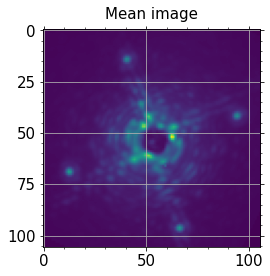

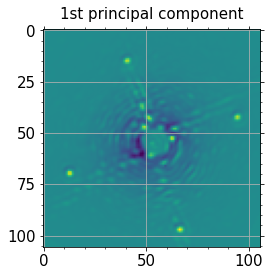

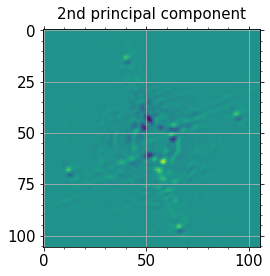

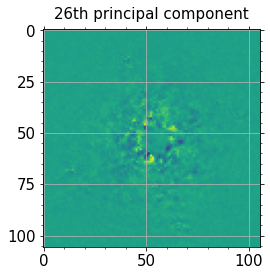

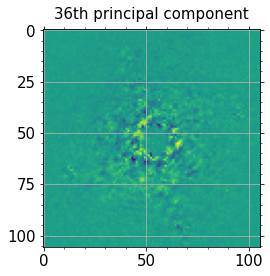

In [13]:
images = fits.open("image_cropped.fits")[0].data

# We must fund the mean of the all images. Given that these lie along the 1st dimension:
mean_image = np.mean(images, axis=0)
residuals = images - mean_image
residuals = np.reshape(residuals, (images.shape[0], -1))
# Perform PCA
U, W, V_T = np.linalg.svd(residuals, full_matrices=False)
bases = np.reshape(V_T, images.shape)

def plot_image(image, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image)
    ax.set_title(title, fontsize=15, y=1.02)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

plot_image(mean_image, 'Mean image')
plot_image(bases[0], '1st principal component')
plot_image(bases[1], '2nd principal component')
plot_image(bases[25], '26th principal component')
plot_image(bases[35], '36th principal component')

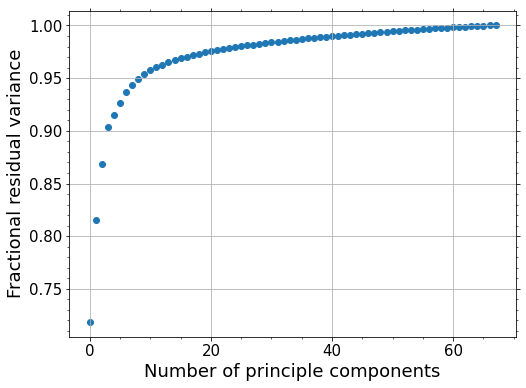

In [14]:
# Now plot the the residual variance as a function of the number of principal components
variance_frac = np.cumsum(W**2)/np.sum(W**2)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.scatter(range(len(W)), variance_frac)
ax.set_xlabel('Number of principle components', fontsize=18)
ax.set_ylabel('Fractional residual variance', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

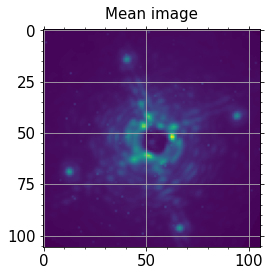

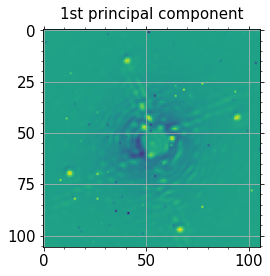

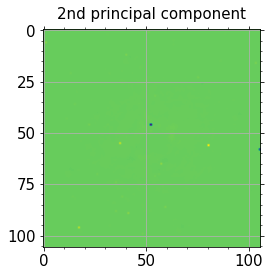

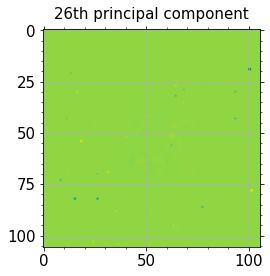

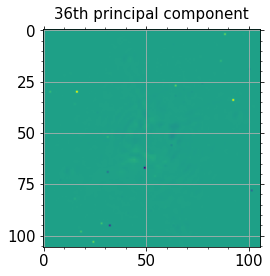

In [15]:
badpix = (np.random.uniform(0, 1, images.shape) > 0.9999)*(images != 0)
badpixval = np.std(images)*100
images += badpix*np.random.uniform(0, badpixval, images.shape)

# Now repeat the same procedure as at the beginning of exercise 3
mean_image = np.mean(images, axis=0)
residuals = images - mean_image
residuals = np.reshape(residuals, (images.shape[0], -1))
# Perform PCA
U, W, V_T = np.linalg.svd(residuals, full_matrices=False)
bases = np.reshape(V_T, images.shape)

plot_image(mean_image, 'Mean image')
plot_image(bases[0], '1st principal component')
plot_image(bases[1], '2nd principal component')
plot_image(bases[25], '26th principal component')
plot_image(bases[35], '36th principal component')